# Multivariate Normal Likelihood with Multivariate Normal Prior

This is a simple model where our data, $y$, is modelled as a multivariate normal RV with uncorrelated noise.

$L(x) = p(y | x) = \mathcal{N}[y \mid x,\Sigma]$

and

$p(x) = \mathcal{N}[x \mid \mu, \sigma^2 \mathbf{I}]$.

The analytic evidence for this model is,

$Z = p(y) = \mathcal{N}[y \mid \mu, \Sigma + \sigma^2 \mathbf{I}]$

The posterior is also a multivariate normal distribution,

$p(x \mid y) = \mathcal{N}[\mu', \Sigma']$

where

$\mu' = \sigma^2 \mathbf{I} (\sigma^2 \mathbf{I} + \Sigma)^{-1} y + \Sigma (
    \sigma^2 \mathbf{I} + \Sigma)^{-1}  \mu$

and

$\Sigma' = \sigma^2 \mathbf{I}  (\sigma^2 \mathbf{I}  + \Sigma)^{-1} \Sigma$


In [1]:

import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp

from jaxns import DefaultNestedSampler
from jaxns import Model
from jaxns import Prior

tfpd = tfp.distributions

INFO[2023-12-20 21:27:43,820]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-12-20 21:27:43,821]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-12-20 21:27:43,822]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
WARNING[2023-12-20 21:27:43,823]: An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
from jax._src.scipy.linalg import solve_triangular


def log_normal(x, mean, cov):
    L = jnp.linalg.cholesky(cov)
    dx = x - mean
    dx = solve_triangular(L, dx, lower=True)
    return -0.5 * x.size * jnp.log(2. * jnp.pi) - jnp.sum(jnp.log(jnp.diag(L))) - 0.5 * dx @ dx


# define our data and prior
ndims = 8
prior_mu = 15 * jnp.ones(ndims)
prior_cov = jnp.diag(jnp.ones(ndims)) ** 2

data_mu = jnp.zeros(ndims)
data_cov = jnp.diag(jnp.ones(ndims)) ** 2
data_cov = jnp.where(data_cov == 0., 0.99, data_cov)

true_logZ = log_normal(data_mu, prior_mu, prior_cov + data_cov)

J = jnp.linalg.solve(data_cov + prior_cov, prior_cov)
post_mu = prior_mu + J.T @ (data_mu - prior_mu)
post_cov = prior_cov - J.T @ (prior_cov + data_cov) @ J

print("True logZ={}".format(true_logZ))
print("True post_mu={}".format(post_mu))
print("True post_cov={}".format(post_cov))


True logZ=-109.2649154663086
True post_mu=[13.320267 13.32027  13.320268 13.320269 13.32027  13.320269 13.320269
 13.32027 ]
True post_cov=[[0.11966532 0.10976463 0.10976463 0.10976469 0.10976461 0.10976458
  0.10976458 0.10976458]
 [0.10976453 0.11966574 0.10976461 0.1097647  0.10976458 0.10976461
  0.10976455 0.10976464]
 [0.10976464 0.10976465 0.11966532 0.10976467 0.10976462 0.10976464
  0.10976461 0.10976463]
 [0.10976461 0.10976464 0.10976467 0.11966532 0.10976463 0.10976464
  0.10976452 0.10976458]
 [0.10976461 0.10976468 0.10976459 0.10976467 0.11966562 0.10976462
  0.10976456 0.10976462]
 [0.1097646  0.1097646  0.10976466 0.1097646  0.10976463 0.11966538
  0.10976466 0.10976465]
 [0.10976455 0.10976463 0.10976458 0.10976461 0.10976452 0.10976464
  0.1196658  0.10976465]
 [0.10976458 0.10976466 0.10976461 0.10976464 0.10976455 0.10976467
  0.10976455 0.11966562]]


In [3]:



def prior_model():
    x = yield Prior(tfpd.MultivariateNormalTriL(loc=prior_mu, scale_tril=jnp.linalg.cholesky(prior_cov)), name='x')
    return x


# The likelihood is a callable that will take
def log_likelihood(x):
    return log_normal(x, data_mu, data_cov)


model = Model(prior_model=prior_model,
              log_likelihood=log_likelihood)


In [4]:
import jax

# Create the nested sampler class. In this case without any tuning.
ns = DefaultNestedSampler(model=model, max_samples=1e6, parameter_estimation=True)

termination_reason, state = jax.jit(ns)(random.PRNGKey(42654))
results = ns.to_results(termination_reason=termination_reason, state=state)

# We can always save results to play with later
ns.save_results(results, 'save.npz')
# loads previous results by uncommenting below
# results = load_results('save.npz')



--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 1079762
samples: 59760
phantom samples: 47040
likelihood evals / sample: 18.1
phantom fraction (%): 78.7%
--------
logZ=-109.35 +- 0.35
H=-23.38
ESS=2178
--------
x[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
x[0]: 13.38 +- 0.35 | 12.93 / 13.39 / 13.82 | 13.38 | 11.91
x[1]: 13.38 +- 0.35 | 12.93 / 13.38 / 13.82 | 13.42 | 11.86
x[2]: 13.38 +- 0.35 | 12.92 / 13.4 / 13.81 | 13.33 | 11.9
x[3]: 13.38 +- 0.35 | 12.93 / 13.39 / 13.83 | 13.35 | 12.0
x[4]: 13.38 +- 0.35 | 12.93 / 13.38 / 13.82 | 13.35 | 11.9
x[5]: 13.38 +- 0.35 | 12.93 / 13.39 / 13.82 | 13.37 | 11.96
x[6]: 13.39 +- 0.35 | 12.92 / 13.41 / 13.82 | 13.35 | 11.89
x[7]: 13.38 +- 0.35 | 12.92 / 13.39 / 13.81 | 13.36 | 11.97
--------


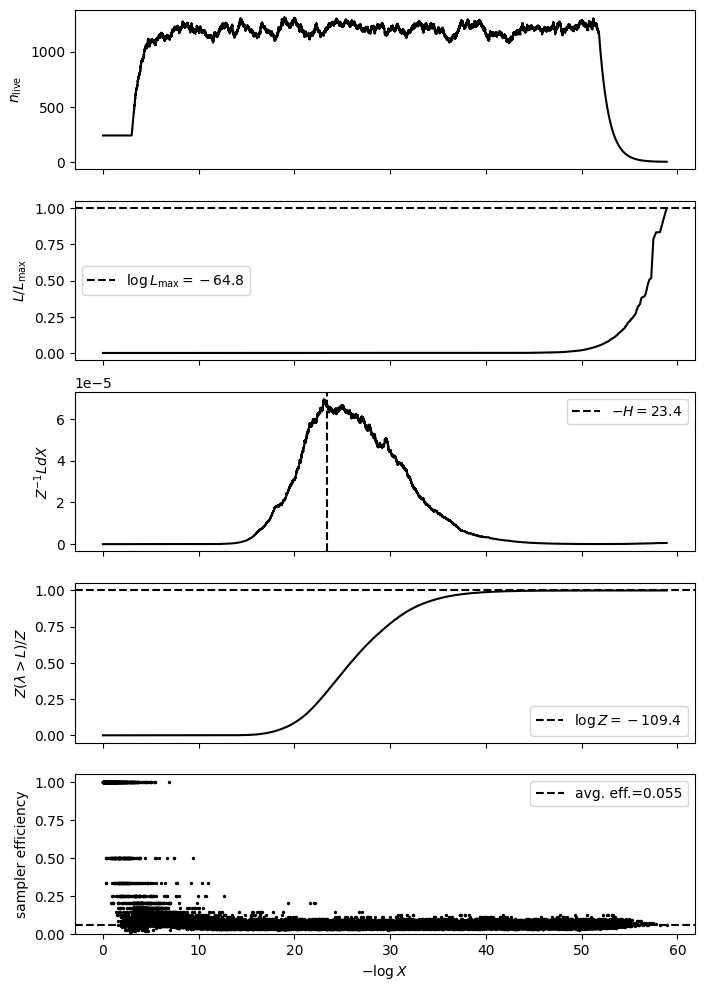

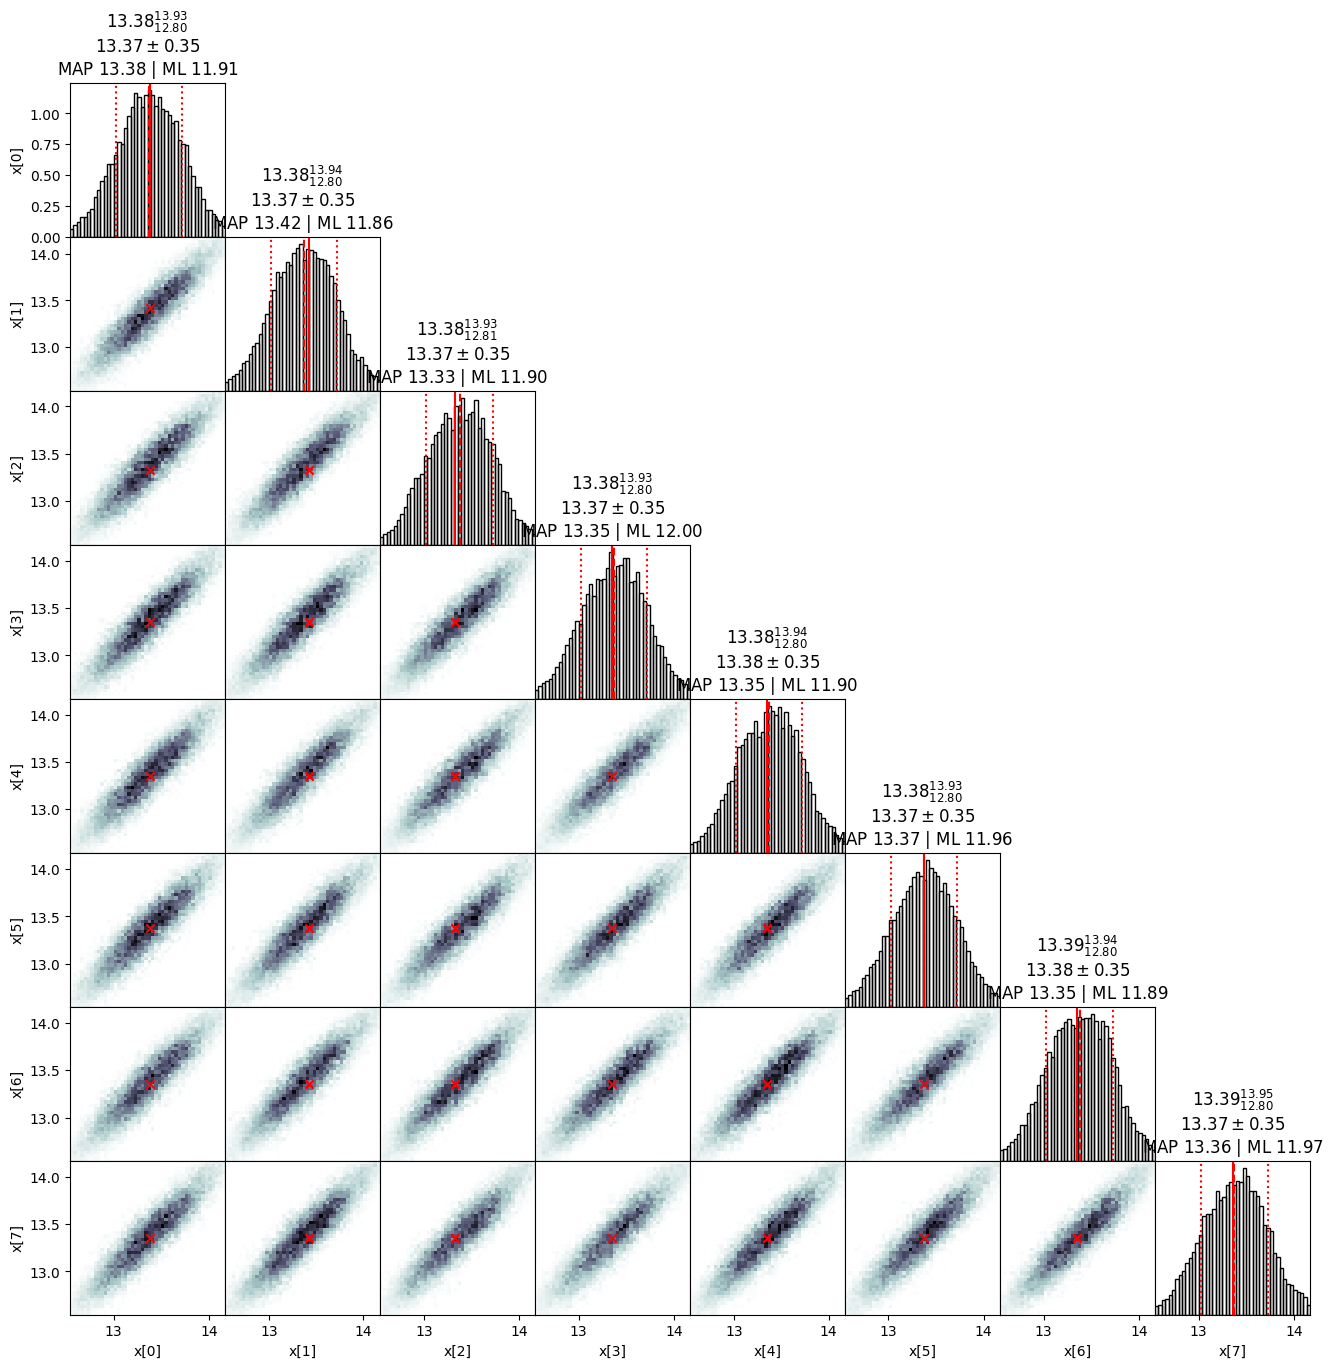

In [5]:
# We can use the summary utility to display results
ns.summary(results)
# We plot useful diagnostics and a distribution cornerplot
ns.plot_diagnostics(results)
ns.plot_cornerplot(results)
